In [2]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [16]:
tf.logging.set_verbosity(tf.logging.INFO)

In [17]:
def cnn_model_fn(features, labels, mode):
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [18]:
((train_data, train_labels), (eval_data, eval_labels)) = tf.keras.datasets.mnist.load_data()

train_data = train_data/np.float32(255)
train_labels = train_labels.astype(np.int32)

eval_data = eval_data/np.float32(255)
eval_labels = eval_labels.astype(np.int32)

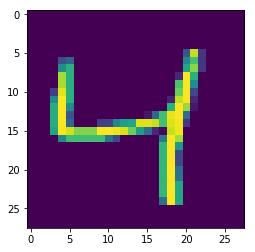

It is 4


In [19]:
plt.imshow(train_data[2])
plt.show()
print("It is {0}".format(train_labels[2]))

In [20]:
mnist_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="c:/dev/rdata_science/temp/model_dir/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'c:/dev/rdata_science/temp/model_dir/mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000018D049253C8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [21]:
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

In [22]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

# train one step and display the probabilties
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=1,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into c:/dev/rdata_science/temp/model_dir/mnist_convnet_model\model.ckpt.
INFO:tensorflow:probabilities = [[0.09842867 0.09718438 0.10000472 0.10863841 0.09071804 0.10309198
  0.0952247  0.09943337 0.10359011 0.10368561]
 [0.10320599 0.09944966 0.09900359 0.10935739 0.09196538 0.10853935
  0.10800037 0.09133566 0.09326322 0.09587943]
 [0.1002922  0.08766492 0.09223883 0.10765161 0.09366051 0.11053383
  0.10666087 0.09542354 0.09785434 0.10801943]
 [0.10655732 0.09148717 0.09592098 0.10190972 0.10479014 0.10386652
  0.09841811 0.09451513 0.10356914 0.09896586]
 [0.10547812 0.09242497 0.10410903 0.10745876 0.09093101 0.11369557
  0.10034398 0.0884771  0.09267376 0.10440778]
 [0.0945349  0.09798688 0.09911461 0.11009

INFO:tensorflow:loss = 2.297583, step = 1
INFO:tensorflow:Saving checkpoints for 1 into c:/dev/rdata_science/temp/model_dir/mnist_convnet_model\model.ckpt.
INFO:tensorflow:Loss for final step: 2.297583.


In [23]:
mnist_classifier.train(input_fn=train_input_fn, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from c:/dev/rdata_science/temp/model_dir/mnist_convnet_model\model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into c:/dev/rdata_science/temp/model_dir/mnist_convnet_model\model.ckpt.
INFO:tensorflow:loss = 2.3098304, step = 2
INFO:tensorflow:global_step/sec: 6.41271
INFO:tensorflow:loss = 2.2923396, step = 102 (15.596 sec)
INFO:tensorflow:global_step/sec: 6.35531
INFO:tensorflow:loss = 2.2846842, step = 202 (15.735 sec)
INFO:tensorflow:global_step/sec: 6.30646
INFO:tensorflow:loss = 2.270977, step = 302 (15.856 sec)
INFO:tensorflow:global_step/sec: 4.97923
INFO:tensorflow:loss = 2.2597523, step = 402 (20.084 sec)
INFO:tensorflow:global_step/sec: 5.63069
INFO:tensorflow:loss = 2.2204516, step = 502 (17.759 sec)
I

In [24]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)

eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-20T10:09:14Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from c:/dev/rdata_science/temp/model_dir/mnist_convnet_model\model.ckpt-1001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-20-10:09:19
INFO:tensorflow:Saving dict for global step 1001: accuracy = 0.6636, global_step = 1001, loss = 2.0801141
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1001: c:/dev/rdata_science/temp/model_dir/mnist_convnet_model\model.ckpt-1001
{'accuracy': 0.6636, 'loss': 2.0801141, 'global_step': 1001}


In [25]:
pred_inout_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    shuffle=False
)

pred_res = mnist_classifier.predict(input_fn=pred_inout_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from c:/dev/rdata_science/temp/model_dir/mnist_convnet_model\model.ckpt-1001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'classes': 3, 'probabilities': array([0.10438202, 0.08779541, 0.09686562, 0.13355225, 0.08349268,
       0.09715771, 0.08893447, 0.10175879, 0.10847678, 0.09758436],
      dtype=float32)}


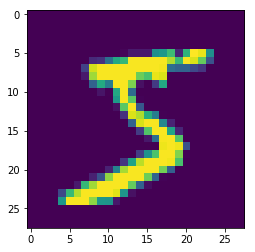

{'classes': 0, 'probabilities': array([0.18281806, 0.06609907, 0.09544432, 0.11300833, 0.07289112,
       0.09214452, 0.10539671, 0.08204427, 0.09981996, 0.0903336 ],
      dtype=float32)}


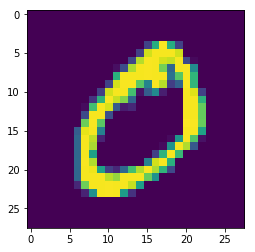

{'classes': 4, 'probabilities': array([0.10674994, 0.07603673, 0.1049655 , 0.10975429, 0.11514625,
       0.09592239, 0.09854156, 0.10413584, 0.08942588, 0.09932166],
      dtype=float32)}


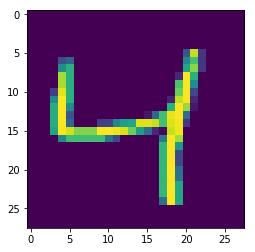

{'classes': 1, 'probabilities': array([0.08760028, 0.11913062, 0.10878275, 0.09937581, 0.09896987,
       0.08642512, 0.09518625, 0.09809892, 0.11598811, 0.0904423 ],
      dtype=float32)}


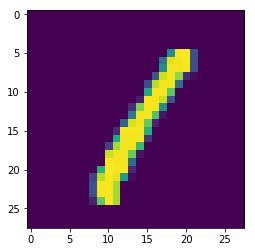

{'classes': 9, 'probabilities': array([0.09380887, 0.08228718, 0.0915498 , 0.09791755, 0.10844188,
       0.09190048, 0.10313175, 0.10263722, 0.10674015, 0.12158522],
      dtype=float32)}


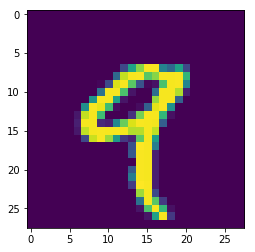

{'classes': 2, 'probabilities': array([0.11720488, 0.07065328, 0.12368476, 0.1099089 , 0.08768851,
       0.09401244, 0.10059504, 0.09268535, 0.10771426, 0.09585254],
      dtype=float32)}


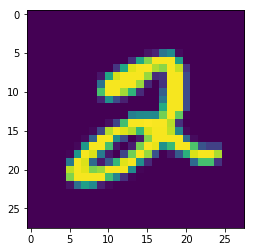

{'classes': 1, 'probabilities': array([0.07433853, 0.12639183, 0.10122635, 0.10644034, 0.09346556,
       0.08393998, 0.10501865, 0.09509198, 0.10665638, 0.10743053],
      dtype=float32)}


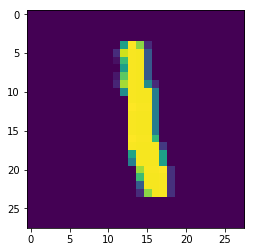

{'classes': 3, 'probabilities': array([0.11539245, 0.06858802, 0.11382568, 0.13442887, 0.07774135,
       0.09369907, 0.0830941 , 0.09444981, 0.11818567, 0.10059498],
      dtype=float32)}


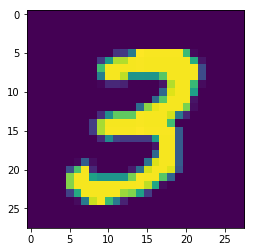

{'classes': 1, 'probabilities': array([0.08127796, 0.12785892, 0.09583977, 0.09822809, 0.09475582,
       0.08736826, 0.10247075, 0.10059803, 0.10273848, 0.10886386],
      dtype=float32)}


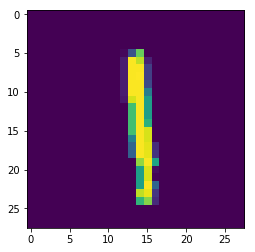

{'classes': 6, 'probabilities': array([0.1000562 , 0.08358643, 0.1054244 , 0.09006318, 0.11219205,
       0.09782791, 0.11232815, 0.09579444, 0.10150402, 0.10122324],
      dtype=float32)}


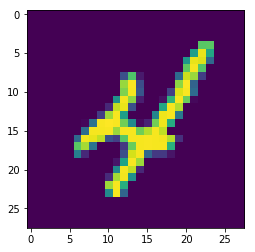

{'classes': 3, 'probabilities': array([0.0896668 , 0.09782566, 0.1035108 , 0.13026512, 0.0786308 ,
       0.08985604, 0.09173854, 0.09475744, 0.12432912, 0.09941966],
      dtype=float32)}


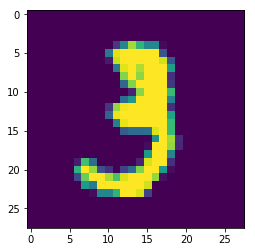

{'classes': 2, 'probabilities': array([0.1051014 , 0.08966253, 0.11430485, 0.09231348, 0.09781893,
       0.09964408, 0.10377344, 0.09147377, 0.11058732, 0.0953202 ],
      dtype=float32)}


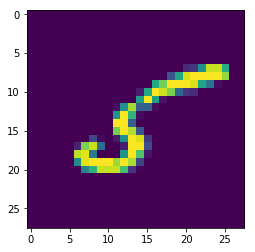

{'classes': 3, 'probabilities': array([0.10999767, 0.07825943, 0.10384893, 0.16046634, 0.07740252,
       0.09312109, 0.09005708, 0.09005967, 0.1077446 , 0.08904265],
      dtype=float32)}


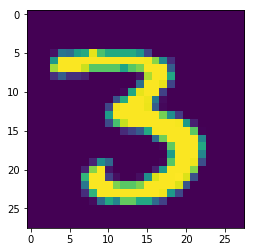

{'classes': 6, 'probabilities': array([0.11470486, 0.08479331, 0.10638508, 0.09598102, 0.09317885,
       0.08497271, 0.14027861, 0.08630642, 0.10012326, 0.09327589],
      dtype=float32)}


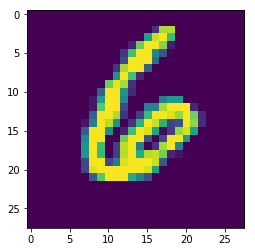

{'classes': 1, 'probabilities': array([0.08158077, 0.13444029, 0.09431669, 0.09833637, 0.09182326,
       0.08733221, 0.10239039, 0.09616048, 0.10719668, 0.1064229 ],
      dtype=float32)}


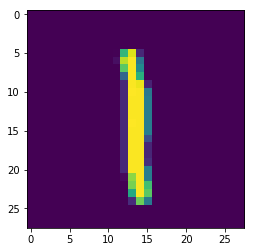

{'classes': 9, 'probabilities': array([0.10297903, 0.08235217, 0.0923326 , 0.10097314, 0.10923884,
       0.08762091, 0.09345684, 0.11394192, 0.10208075, 0.11502379],
      dtype=float32)}


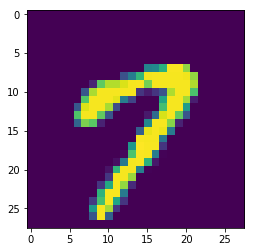

{'classes': 2, 'probabilities': array([0.1061932 , 0.07221837, 0.12341489, 0.11872227, 0.08483772,
       0.09067059, 0.0981307 , 0.10689577, 0.10545269, 0.09346382],
      dtype=float32)}


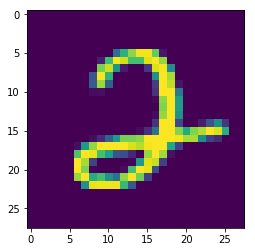

{'classes': 8, 'probabilities': array([0.10638549, 0.09981261, 0.10196256, 0.09967874, 0.09058513,
       0.09117457, 0.09365135, 0.09304846, 0.12951763, 0.0941834 ],
      dtype=float32)}


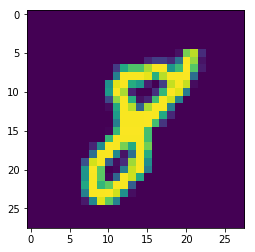

{'classes': 6, 'probabilities': array([0.10669091, 0.09598596, 0.10098208, 0.11161636, 0.08909965,
       0.08674558, 0.11743138, 0.0888349 , 0.10543539, 0.09717777],
      dtype=float32)}


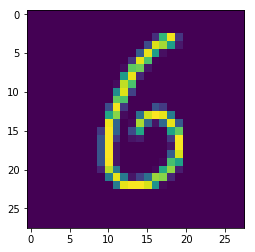

{'classes': 8, 'probabilities': array([0.08994714, 0.11270654, 0.09144539, 0.09938502, 0.09954685,
       0.08621691, 0.09654731, 0.10423893, 0.11357066, 0.10639526],
      dtype=float32)}


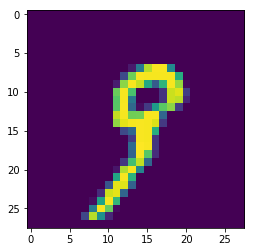

{'classes': 4, 'probabilities': array([0.10144229, 0.07294855, 0.10839461, 0.11069577, 0.1178841 ,
       0.09484234, 0.10110245, 0.10004103, 0.08787846, 0.1047705 ],
      dtype=float32)}


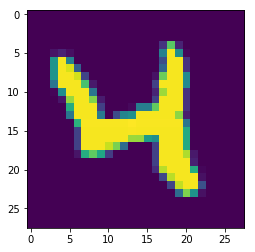

{'classes': 0, 'probabilities': array([0.18427867, 0.06157713, 0.09659007, 0.1106611 , 0.07592836,
       0.09480639, 0.10388333, 0.08214738, 0.10116994, 0.08895758],
      dtype=float32)}


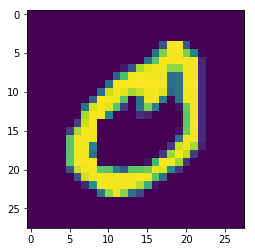

{'classes': 8, 'probabilities': array([0.09052169, 0.10292665, 0.10006694, 0.0947056 , 0.1029829 ,
       0.08559296, 0.10336107, 0.10468878, 0.10972158, 0.10543178],
      dtype=float32)}


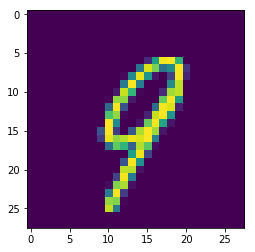

{'classes': 1, 'probabilities': array([0.08770269, 0.11664066, 0.11090732, 0.10022372, 0.09964082,
       0.08426386, 0.0952136 , 0.09901158, 0.11550838, 0.09088739],
      dtype=float32)}


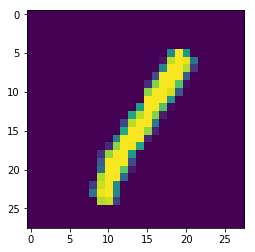

{'classes': 2, 'probabilities': array([0.09826528, 0.10346176, 0.11796517, 0.11269365, 0.08102066,
       0.08692886, 0.10581391, 0.09007731, 0.10623769, 0.09753574],
      dtype=float32)}


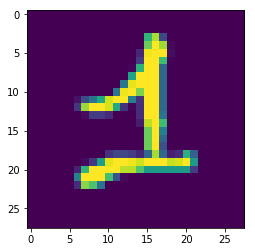

{'classes': 2, 'probabilities': array([0.12204008, 0.06640244, 0.12948117, 0.12594816, 0.06952164,
       0.09527336, 0.09282764, 0.08499385, 0.1276133 , 0.08589835],
      dtype=float32)}


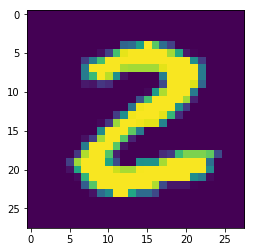

{'classes': 9, 'probabilities': array([0.08327342, 0.08883472, 0.09369253, 0.10107491, 0.11599979,
       0.09284282, 0.09613831, 0.11292048, 0.09915026, 0.11607278],
      dtype=float32)}


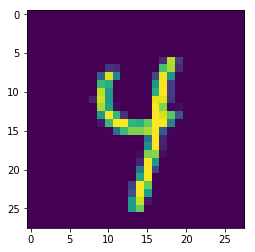

{'classes': 3, 'probabilities': array([0.12349883, 0.06547712, 0.10701133, 0.15715303, 0.0684341 ,
       0.09040359, 0.07673466, 0.09955501, 0.11415846, 0.09757378],
      dtype=float32)}


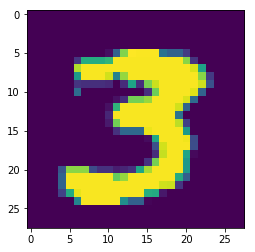

{'classes': 3, 'probabilities': array([0.10571557, 0.07692899, 0.10146301, 0.12751691, 0.08814717,
       0.08197934, 0.08512072, 0.12590495, 0.11212466, 0.09509866],
      dtype=float32)}


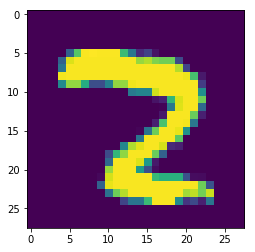

{'classes': 6, 'probabilities': array([0.09409782, 0.09630668, 0.10487908, 0.09446347, 0.10394113,
       0.08700938, 0.10817424, 0.10140418, 0.10694535, 0.10277876],
      dtype=float32)}


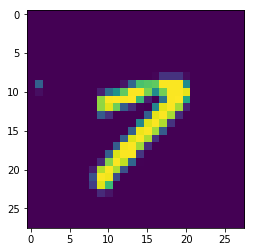

{'classes': 3, 'probabilities': array([0.09383684, 0.08833415, 0.09786425, 0.1236597 , 0.0981548 ,
       0.09511096, 0.10204896, 0.10287933, 0.09575559, 0.10235537],
      dtype=float32)}


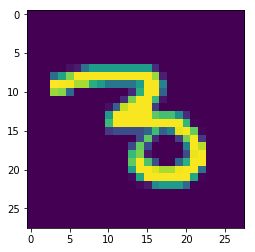

{'classes': 8, 'probabilities': array([0.11834065, 0.09759374, 0.11812773, 0.09948834, 0.07508662,
       0.09066666, 0.09132501, 0.08792461, 0.1322572 , 0.08918945],
      dtype=float32)}


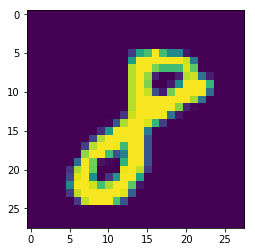

{'classes': 6, 'probabilities': array([0.10450853, 0.09107718, 0.10194141, 0.10887317, 0.08902579,
       0.08788846, 0.13396038, 0.0898472 , 0.09777127, 0.09510664],
      dtype=float32)}


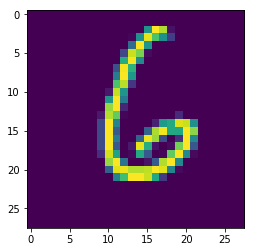

{'classes': 8, 'probabilities': array([0.09534411, 0.10490833, 0.10028075, 0.10367148, 0.09674678,
       0.08366392, 0.08761483, 0.10705131, 0.11432365, 0.10639485],
      dtype=float32)}


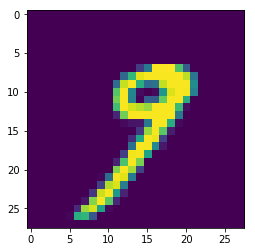

{'classes': 8, 'probabilities': array([0.12325978, 0.08155943, 0.10272287, 0.1120994 , 0.0823024 ,
       0.08809873, 0.10798133, 0.09009202, 0.12345312, 0.08843091],
      dtype=float32)}


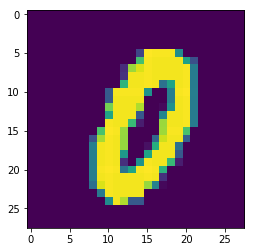

{'classes': 2, 'probabilities': array([0.10194867, 0.09333338, 0.10833717, 0.10527077, 0.09524743,
       0.10289869, 0.09454014, 0.09504329, 0.10537291, 0.09800746],
      dtype=float32)}


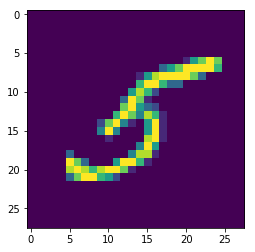

{'classes': 6, 'probabilities': array([0.08894175, 0.10164401, 0.10764192, 0.10705639, 0.08465998,
       0.08698836, 0.13530296, 0.08137479, 0.1101483 , 0.09624156],
      dtype=float32)}


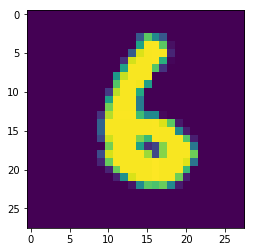

{'classes': 0, 'probabilities': array([0.15119529, 0.07004715, 0.10643151, 0.11498022, 0.07760411,
       0.09111952, 0.10982913, 0.08131184, 0.10936854, 0.0881127 ],
      dtype=float32)}


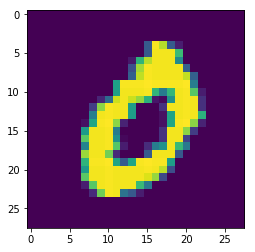

{'classes': 3, 'probabilities': array([0.08263535, 0.08030655, 0.10111376, 0.11566412, 0.10696746,
       0.09307885, 0.10147128, 0.11254516, 0.10023619, 0.10598134],
      dtype=float32)}


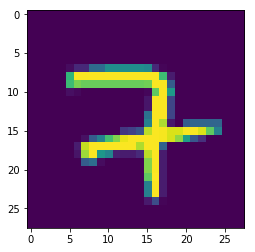

{'classes': 6, 'probabilities': array([0.10147411, 0.0857204 , 0.10497352, 0.10266115, 0.08860503,
       0.08435144, 0.13455513, 0.09280595, 0.10770226, 0.09715104],
      dtype=float32)}


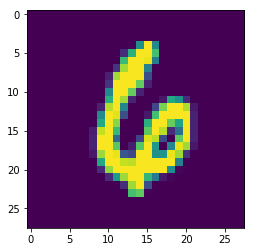

{'classes': 1, 'probabilities': array([0.08091647, 0.14579275, 0.09344096, 0.09447234, 0.08871921,
       0.08439507, 0.09771065, 0.10004044, 0.11135723, 0.10315492],
      dtype=float32)}


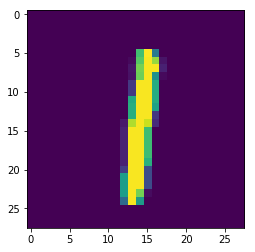

{'classes': 8, 'probabilities': array([0.0955927 , 0.09488115, 0.10177219, 0.10617518, 0.09056883,
       0.086611  , 0.09939564, 0.09617049, 0.13388568, 0.0949472 ],
      dtype=float32)}


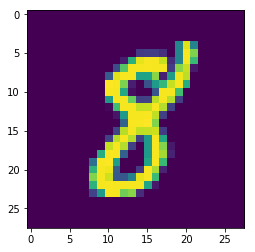

{'classes': 7, 'probabilities': array([0.08567353, 0.10777952, 0.08903863, 0.10242908, 0.10280411,
       0.08831892, 0.08941666, 0.11688803, 0.10486218, 0.11278941],
      dtype=float32)}


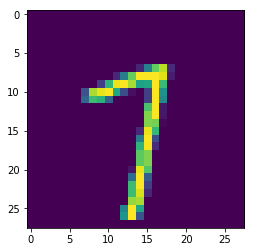

{'classes': 1, 'probabilities': array([0.08606076, 0.11731677, 0.08969256, 0.1018903 , 0.09973731,
       0.08438489, 0.09358026, 0.10700832, 0.11341135, 0.10691741],
      dtype=float32)}


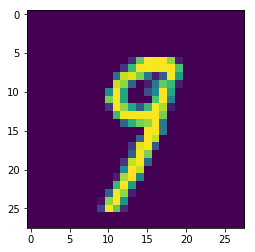

{'classes': 3, 'probabilities': array([0.08460642, 0.0938665 , 0.09664231, 0.12423046, 0.09825521,
       0.09159826, 0.09371578, 0.10607314, 0.10895919, 0.10205279],
      dtype=float32)}


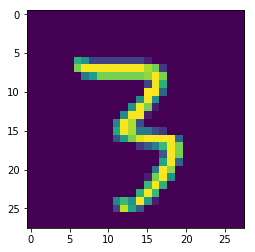

{'classes': 9, 'probabilities': array([0.09596044, 0.08185689, 0.08782373, 0.09797245, 0.10976159,
       0.09167454, 0.0967455 , 0.10754313, 0.10700309, 0.12365865],
      dtype=float32)}


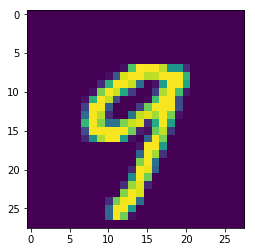

{'classes': 8, 'probabilities': array([0.09328235, 0.09247097, 0.0994367 , 0.11312886, 0.09109474,
       0.09108584, 0.09882754, 0.09586579, 0.12447582, 0.10033141],
      dtype=float32)}


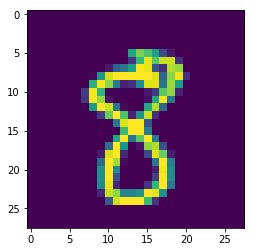

{'classes': 0, 'probabilities': array([0.11726438, 0.08491132, 0.10052541, 0.10721236, 0.08549872,
       0.10265252, 0.09388226, 0.09279568, 0.10915834, 0.10609897],
      dtype=float32)}


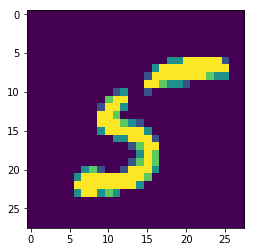

{'classes': 3, 'probabilities': array([0.08949631, 0.09856838, 0.09675717, 0.11599223, 0.09673467,
       0.09815745, 0.1000061 , 0.09513694, 0.10771585, 0.10143498],
      dtype=float32)}


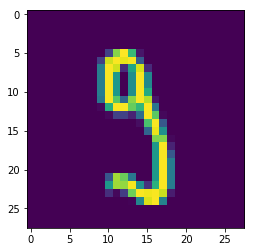

{'classes': 3, 'probabilities': array([0.11155173, 0.08270085, 0.10546664, 0.14001793, 0.07415148,
       0.09331682, 0.08379372, 0.09115078, 0.12259173, 0.09525824],
      dtype=float32)}


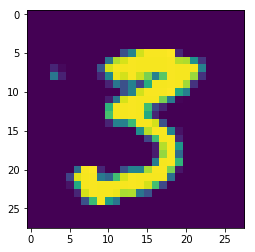

{'classes': 3, 'probabilities': array([0.10279138, 0.08579603, 0.10516291, 0.14256263, 0.08155817,
       0.08946475, 0.09516446, 0.09269278, 0.11367003, 0.09113684],
      dtype=float32)}


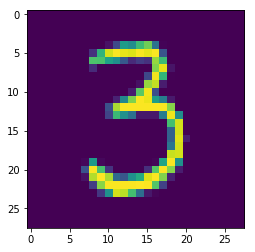

{'classes': 0, 'probabilities': array([0.21276659, 0.05190279, 0.09248029, 0.12610185, 0.06673778,
       0.09570175, 0.09260807, 0.08045644, 0.09178647, 0.08945798],
      dtype=float32)}


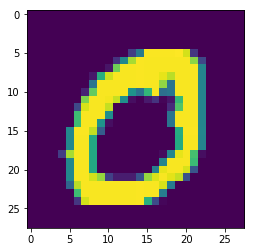

{'classes': 7, 'probabilities': array([0.1106621 , 0.06939444, 0.08220611, 0.11946996, 0.10283417,
       0.08936635, 0.08817566, 0.12934701, 0.09397982, 0.11456453],
      dtype=float32)}


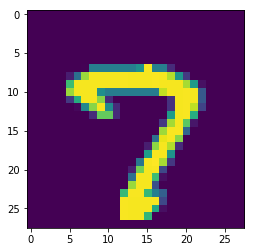

{'classes': 1, 'probabilities': array([0.09452897, 0.10908296, 0.09673455, 0.10005795, 0.10304379,
       0.0905595 , 0.10561398, 0.09547138, 0.100713  , 0.10419391],
      dtype=float32)}


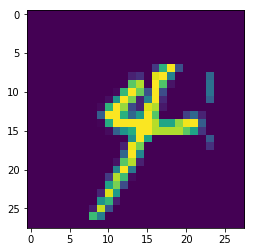

{'classes': 7, 'probabilities': array([0.09561645, 0.07777662, 0.09623537, 0.09673652, 0.11364385,
       0.09777052, 0.09420676, 0.11850419, 0.09418891, 0.11532074],
      dtype=float32)}


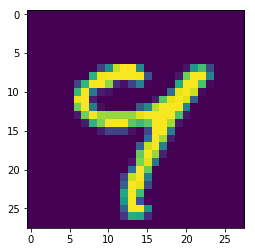

{'classes': 8, 'probabilities': array([0.10153299, 0.08735442, 0.10384574, 0.10565764, 0.09023015,
       0.08853841, 0.09086705, 0.1016856 , 0.12733342, 0.10295464],
      dtype=float32)}


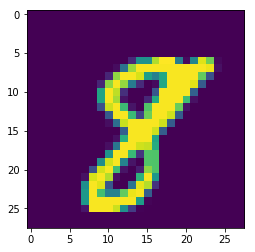

{'classes': 0, 'probabilities': array([0.20336562, 0.05892443, 0.09230185, 0.1145738 , 0.0689545 ,
       0.1017052 , 0.10862244, 0.07249869, 0.09641337, 0.08264013],
      dtype=float32)}


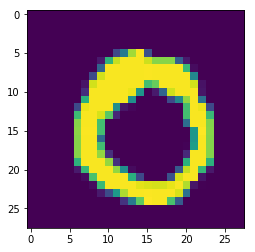

{'classes': 9, 'probabilities': array([0.0887858 , 0.09176626, 0.09414518, 0.09948055, 0.10683517,
       0.08864189, 0.0965006 , 0.10781199, 0.10926879, 0.11676385],
      dtype=float32)}


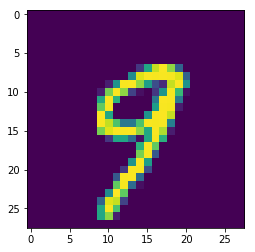

{'classes': 3, 'probabilities': array([0.09528803, 0.06712127, 0.09687092, 0.11767419, 0.11567863,
       0.09003387, 0.09722973, 0.10106529, 0.10187878, 0.11715927],
      dtype=float32)}


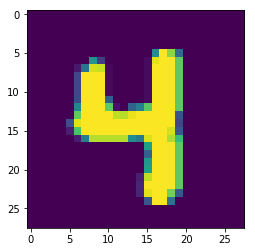

{'classes': 1, 'probabilities': array([0.08973286, 0.12190298, 0.10458789, 0.09995385, 0.09713095,
       0.08706146, 0.10029015, 0.09633896, 0.11561693, 0.08738393],
      dtype=float32)}


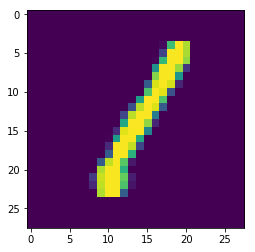

{'classes': 0, 'probabilities': array([0.13784409, 0.06461356, 0.1086155 , 0.11099432, 0.10539002,
       0.09391855, 0.10226449, 0.10111377, 0.07985173, 0.09539384],
      dtype=float32)}


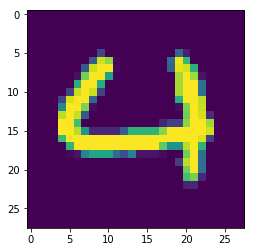

{'classes': 6, 'probabilities': array([0.09308492, 0.10161698, 0.10649314, 0.09733659, 0.10627174,
       0.09094447, 0.10716297, 0.09088784, 0.10474587, 0.10145546],
      dtype=float32)}


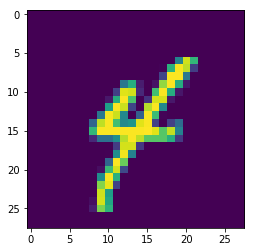

{'classes': 6, 'probabilities': array([0.10364401, 0.08759989, 0.09913371, 0.11165422, 0.08707384,
       0.09037579, 0.12677413, 0.08452822, 0.11773009, 0.09148605],
      dtype=float32)}


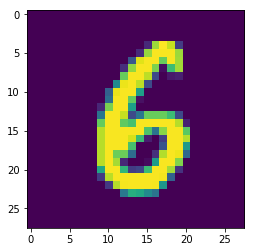

{'classes': 0, 'probabilities': array([0.1982611 , 0.05823244, 0.09210168, 0.12514365, 0.06982601,
       0.08913758, 0.10101701, 0.07186275, 0.09828482, 0.09613298],
      dtype=float32)}


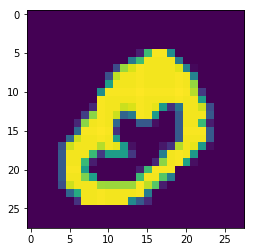

{'classes': 0, 'probabilities': array([0.12124582, 0.06826295, 0.10557823, 0.10270419, 0.10358831,
       0.10417242, 0.113648  , 0.08854811, 0.09657985, 0.0956722 ],
      dtype=float32)}


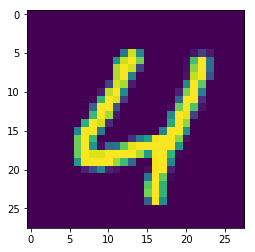

{'classes': 0, 'probabilities': array([0.11158796, 0.09531719, 0.10732792, 0.09392666, 0.09617545,
       0.09836509, 0.10277778, 0.08523229, 0.10947159, 0.0998181 ],
      dtype=float32)}


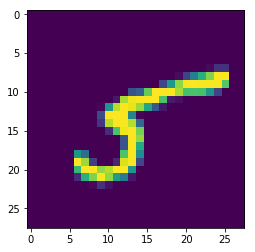

{'classes': 6, 'probabilities': array([0.11995301, 0.08559969, 0.10527077, 0.10513186, 0.08840726,
       0.09121288, 0.13524728, 0.07794043, 0.10276567, 0.08847122],
      dtype=float32)}


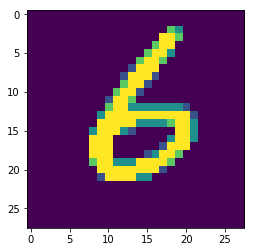

{'classes': 1, 'probabilities': array([0.08299132, 0.1346942 , 0.098372  , 0.09927102, 0.09392083,
       0.08372406, 0.09835933, 0.09746826, 0.11539854, 0.09580047],
      dtype=float32)}


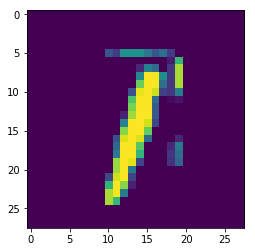

{'classes': 0, 'probabilities': array([0.16018097, 0.07168724, 0.11280406, 0.11629371, 0.07689353,
       0.09522066, 0.10055882, 0.08919527, 0.0907512 , 0.08641459],
      dtype=float32)}


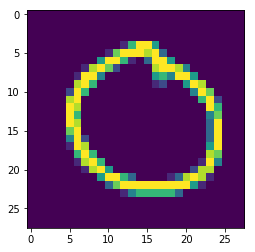

{'classes': 0, 'probabilities': array([0.14473006, 0.06197131, 0.10042205, 0.12633759, 0.0734157 ,
       0.09302498, 0.1089633 , 0.08505294, 0.11300718, 0.09307493],
      dtype=float32)}


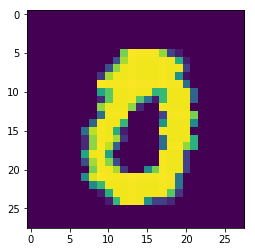

{'classes': 1, 'probabilities': array([0.08678511, 0.11760325, 0.10018813, 0.11426318, 0.08546143,
       0.08627538, 0.10866059, 0.09413481, 0.11056913, 0.09605889],
      dtype=float32)}


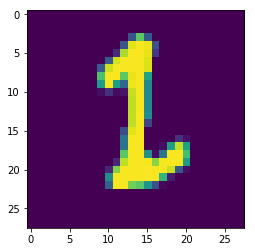

{'classes': 9, 'probabilities': array([0.10381052, 0.09306562, 0.09739871, 0.10106889, 0.10097303,
       0.08729051, 0.09431778, 0.10409408, 0.10462456, 0.11335636],
      dtype=float32)}


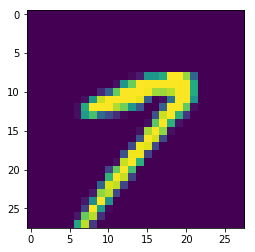

{'classes': 1, 'probabilities': array([0.08264618, 0.13848133, 0.09703185, 0.09560158, 0.09011352,
       0.08607253, 0.10166648, 0.09960383, 0.10550563, 0.10327707],
      dtype=float32)}


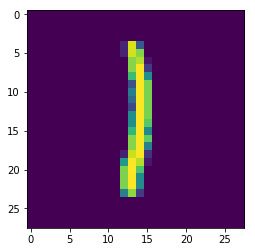

{'classes': 6, 'probabilities': array([0.10399025, 0.09426521, 0.10660606, 0.1023655 , 0.08721155,
       0.08626057, 0.13287286, 0.08674253, 0.10721772, 0.09246776],
      dtype=float32)}


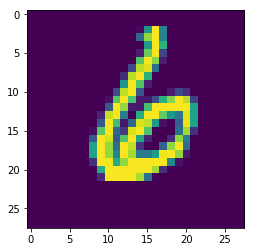

{'classes': 3, 'probabilities': array([0.08817235, 0.08919831, 0.10193522, 0.13807817, 0.08975855,
       0.09258667, 0.0891589 , 0.09341071, 0.11679269, 0.10090835],
      dtype=float32)}


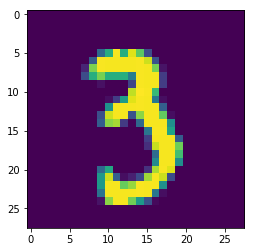

{'classes': 0, 'probabilities': array([0.15589227, 0.06721346, 0.10001509, 0.12675141, 0.07474363,
       0.09402627, 0.10084178, 0.07907344, 0.10743549, 0.09400717],
      dtype=float32)}


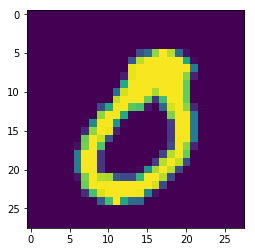

{'classes': 8, 'probabilities': array([0.09522156, 0.09346934, 0.11288147, 0.12069101, 0.0832977 ,
       0.08643285, 0.09829281, 0.09831859, 0.12197867, 0.08941586],
      dtype=float32)}


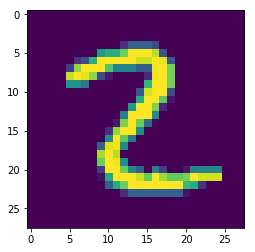

{'classes': 1, 'probabilities': array([0.08949509, 0.13234143, 0.10229623, 0.09884574, 0.0917966 ,
       0.08167925, 0.10087974, 0.09508177, 0.12065277, 0.0869315 ],
      dtype=float32)}


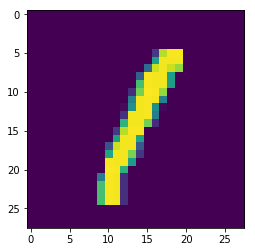

{'classes': 1, 'probabilities': array([0.07739519, 0.12676163, 0.10697143, 0.09906573, 0.0984195 ,
       0.08032004, 0.09190653, 0.10507626, 0.11799453, 0.09608909],
      dtype=float32)}


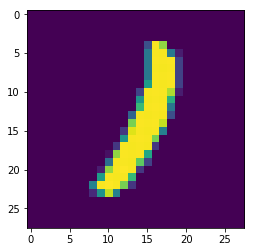

{'classes': 9, 'probabilities': array([0.10760792, 0.09200554, 0.09945805, 0.10365703, 0.10111435,
       0.08710597, 0.08999213, 0.10055146, 0.10697734, 0.11153019],
      dtype=float32)}


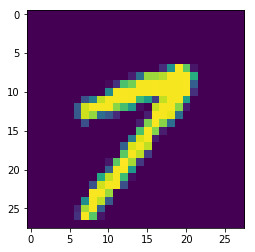

{'classes': 0, 'probabilities': array([0.13257325, 0.06774215, 0.10203557, 0.12289824, 0.08175862,
       0.09551898, 0.1099098 , 0.08877244, 0.10908221, 0.08970876],
      dtype=float32)}


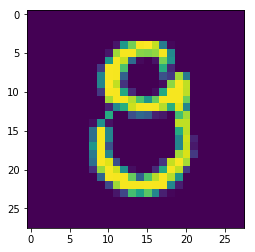

{'classes': 0, 'probabilities': array([0.14977811, 0.06715702, 0.09877834, 0.12110537, 0.07613186,
       0.09397538, 0.10265455, 0.08634646, 0.11084559, 0.09322739],
      dtype=float32)}


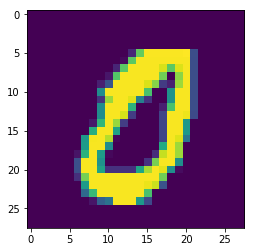

{'classes': 2, 'probabilities': array([0.12452477, 0.06278395, 0.13335413, 0.12974831, 0.07702336,
       0.0891879 , 0.10454555, 0.08818108, 0.10780858, 0.08284233],
      dtype=float32)}


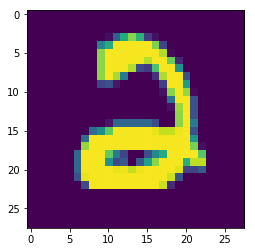

{'classes': 6, 'probabilities': array([0.12105158, 0.07999876, 0.10629253, 0.10503247, 0.08561934,
       0.08712641, 0.13305382, 0.08591989, 0.09965769, 0.09624744],
      dtype=float32)}


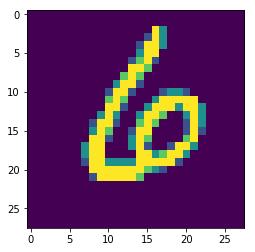

{'classes': 7, 'probabilities': array([0.09354998, 0.0829968 , 0.09242363, 0.11834843, 0.10076999,
       0.08705835, 0.08522852, 0.13666372, 0.09529451, 0.1076661 ],
      dtype=float32)}


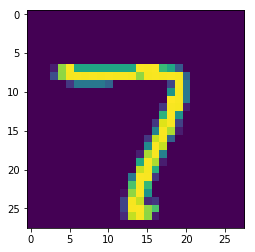

{'classes': 8, 'probabilities': array([0.10037997, 0.0932993 , 0.11117031, 0.10960104, 0.08565074,
       0.08721993, 0.0935416 , 0.09742544, 0.12381665, 0.09789509],
      dtype=float32)}


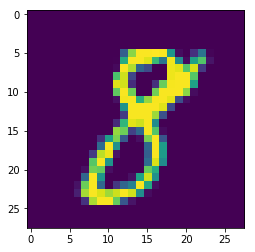

{'classes': 3, 'probabilities': array([0.10373027, 0.08985346, 0.10164484, 0.13293014, 0.08979115,
       0.09892449, 0.10056589, 0.09630147, 0.09661127, 0.08964709],
      dtype=float32)}


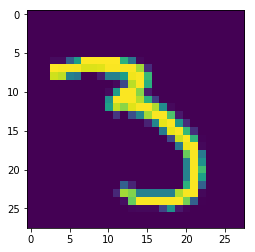

{'classes': 9, 'probabilities': array([0.10098726, 0.08212384, 0.09333705, 0.09608809, 0.10679718,
       0.09254137, 0.1005604 , 0.10538051, 0.10988522, 0.1122991 ],
      dtype=float32)}


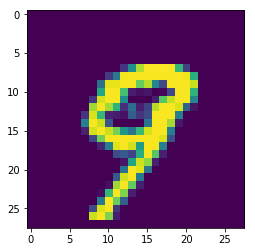

{'classes': 0, 'probabilities': array([0.18526205, 0.06011158, 0.0967703 , 0.12509917, 0.07214818,
       0.0943121 , 0.10496289, 0.07923338, 0.09174626, 0.09035409],
      dtype=float32)}


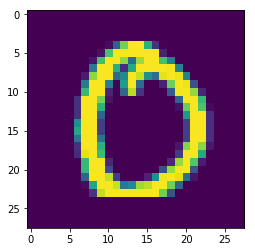

{'classes': 0, 'probabilities': array([0.11570615, 0.07339595, 0.10109945, 0.09181623, 0.11421601,
       0.10435977, 0.10698992, 0.09652068, 0.09375351, 0.1021423 ],
      dtype=float32)}


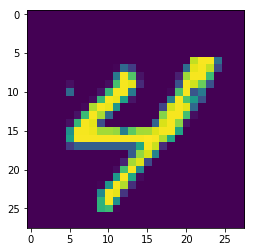

{'classes': 6, 'probabilities': array([0.12229179, 0.07481264, 0.10041095, 0.10131297, 0.09365635,
       0.09034472, 0.14577165, 0.08380143, 0.09639013, 0.09120733],
      dtype=float32)}


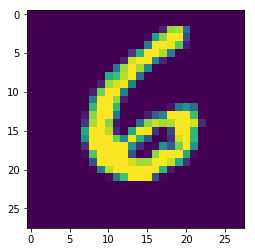

{'classes': 0, 'probabilities': array([0.11783826, 0.08164749, 0.09391043, 0.10481779, 0.10297513,
       0.09038667, 0.08989257, 0.1077702 , 0.09698489, 0.11377659],
      dtype=float32)}


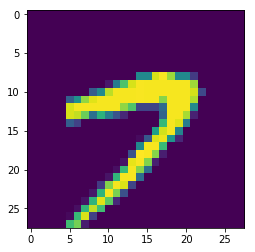

{'classes': 4, 'probabilities': array([0.09397712, 0.07790651, 0.10334685, 0.10878925, 0.11570481,
       0.09176968, 0.10563347, 0.09797422, 0.09790532, 0.10699281],
      dtype=float32)}


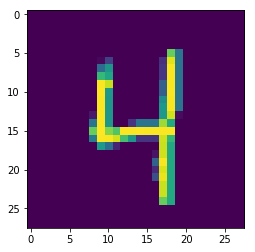

{'classes': 6, 'probabilities': array([0.11310792, 0.08931099, 0.10436086, 0.10484027, 0.0842599 ,
       0.08514545, 0.12743264, 0.08653025, 0.11248599, 0.09252571],
      dtype=float32)}


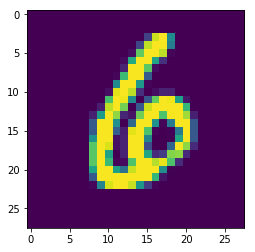

{'classes': 8, 'probabilities': array([0.09575385, 0.1027993 , 0.09786083, 0.10058034, 0.09247685,
       0.08817767, 0.09846105, 0.10125377, 0.12144833, 0.10118804],
      dtype=float32)}


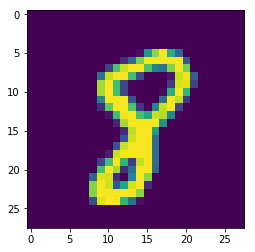

{'classes': 0, 'probabilities': array([0.15247913, 0.06646753, 0.10157635, 0.11801397, 0.07508397,
       0.0907582 , 0.11234486, 0.0843045 , 0.10681293, 0.09215853],
      dtype=float32)}


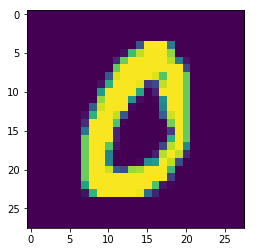

{'classes': 7, 'probabilities': array([0.08230018, 0.09714542, 0.0883656 , 0.10408755, 0.10719159,
       0.08366872, 0.08895957, 0.12715645, 0.10393366, 0.11719118],
      dtype=float32)}


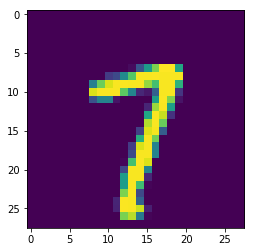

{'classes': 8, 'probabilities': array([0.10145297, 0.09146169, 0.10231673, 0.10051642, 0.08627196,
       0.09037416, 0.09516993, 0.10082517, 0.13220653, 0.09940445],
      dtype=float32)}


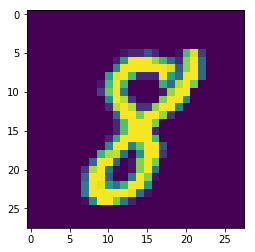

{'classes': 3, 'probabilities': array([0.09094796, 0.09111221, 0.09889586, 0.13648392, 0.08690929,
       0.08934497, 0.09335299, 0.09987637, 0.11472655, 0.09834989],
      dtype=float32)}


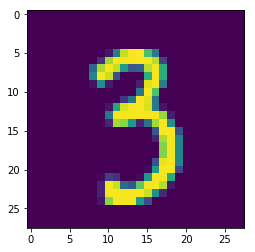

{'classes': 1, 'probabilities': array([0.08210169, 0.12674108, 0.10746548, 0.10062107, 0.09792692,
       0.08156098, 0.09040369, 0.10519296, 0.11250372, 0.09548233],
      dtype=float32)}


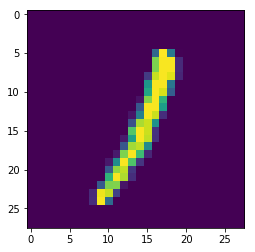

In [26]:
for i in range(100):
    print(next(pred_res))
    plt.imshow(train_data[i])
    plt.show()

In [15]:
x = tf.feature_column.numeric_column("x")
feature_columns = [x]
feature_spec = tf.feature_column.make_parse_example_spec(feature_columns)
export_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)
mnist_classifier.export_savedmodel("c:/dev/rdata_science/temp", export_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tmp/mnist_convnet_model\model.ckpt-3003
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: c:/dev/rdata_science/temp\temp-b'1550656149'\saved_model.pb


b'c:/dev/rdata_science/temp\\1550656149'